In [1]:
import torch
import numpy as np
from copy import deepcopy
from typing import OrderedDict
from recovering import label_recovery
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
import lpips
from matplotlib import pyplot as plt
loss_fn = lpips.LPIPS(net='alex')
seed=100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.enabled = False 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from time import time


1.12.1 0.13.1
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/yanbo.wang/data/anaconda3/envs/cripac/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yanbo.wang/data/anaconda3/envs/cripac/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/yanbo.wang/data/anaconda3/envs/cripac/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [2]:
CONFIG=OrderedDict(device=torch.device('cuda:0'),
    dataset="flowers",
    network="fc",
    opt="lbfgs",
    type='label_smooth',
    pretrained=False,
    lr=0.5,
    bound=100,
    iteration=200,
    initia=1.,
    coefficient=1)
test=label_recovery(CONFIG)
test.datadir='/home/yanbo.wang/'+test.datadir
test.datalist='/home/yanbo.wang/'+test.datalist

训练得到结果进行比对

In [3]:
prob=np.random.uniform(0,0.5)
test.size=(64,64)
print(prob)
test.setup(0,prob)

0.2717024708954827


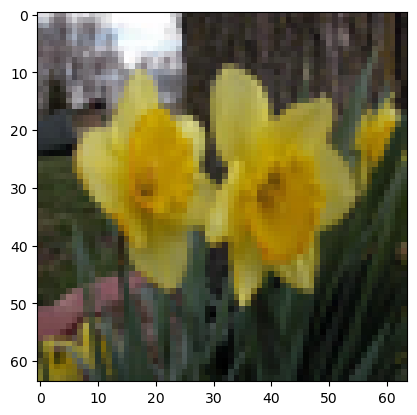

In [4]:
plt.imshow(test.tp(test.origin_data.reshape((3,64,64))))

skip!
skip!
skip!
skip!
skip!
skip!
skip!
flip!
epoch is 32
4.183154582977295


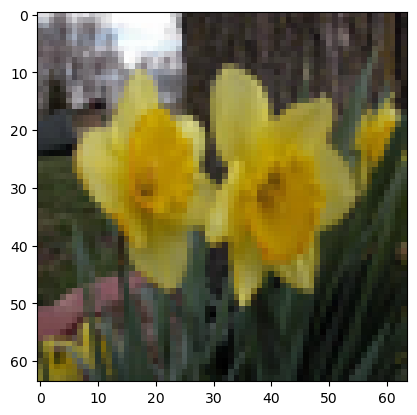

In [5]:
start=time()
test.label_reco()
params=dict(test.net.named_parameters())
pi_yi=torch.div(test.gradient,test.recover_tensor).nanmean(1)
result3=deepcopy(test.recover_tensor).reshape(1,-1)
result3.require_grad_=True
params["fc4.weight"].data.shape
#pi_yi.reshape(1,-1).shape
result3.grad=torch.mm(pi_yi.reshape(1,-1),params["fc4.weight"].data)
for index,i in enumerate(result3[0]):
    if i==0:
        result3.grad[0][index]=0 
fc3_list=[]
for index,i in enumerate(params["fc3.weight"].grad.cpu()):
    if i.sum()!=0:
        fc3_list.append(np.array(i/result3.grad[0][index].cpu()))
    else:
        result3.grad[0][index]=0
result2=torch.Tensor(np.array(fc3_list).mean(axis=0)).reshape(1,-1)  
result2.requires_grad_=True
result2.grad=torch.mm(result3.grad.cpu(),params["fc3.weight"].data.cpu())
for index,i in enumerate(result2[0]):
    if i==0:
        result2.grad[0][index]=0 
fc2_list=[]
for index,i in enumerate(params["fc2.weight"].grad.cpu()):
    if i.sum()!=0:
        fc2_list.append(np.array(i/result2.grad[0][index]))
result1=torch.Tensor(np.array(fc2_list).mean(axis=0)).reshape(1,-1)  
result1.requires_grad_=True
result1.grad=torch.mm(result2.grad,params["fc2.weight"].data.cpu())
for index,i in enumerate(result1[0]):
    if i==0:
        result1.grad[0][index]=0 
fc1_list=[]
for index,i in enumerate(params["fc1.weight"].grad.cpu()):
    if i.sum()!=0:
        fc1_list.append(np.array(i/result1.grad[0][index]))
result0=torch.Tensor(np.array(fc1_list).mean(axis=0)).reshape(1,-1) 
result0=result0.reshape(3,64,64)  
pil_image=test.tp(result0)
end=time()
plt.imshow(pil_image)
print(end-start)

In [6]:
psnr=PSNR(np.asarray(test.tp(test.origin_data.reshape((3,64,64)))), np.asarray(pil_image),data_range=256)
ssim=SSIM(np.asarray(test.tp(test.origin_data.reshape((3,64,64)))), np.asarray(pil_image),channel_axis=2)
test.tp(test.origin_data.reshape((3,64,64))).save('gt.jpg')
pil_image.save('fc_recovery.jpg')
lpipss=loss_fn.forward(lpips.im2tensor(lpips.load_image('gt.jpg')),lpips.im2tensor(lpips.load_image('fc_recovery.jpg')))
print(ssim)
print(psnr)
print(lpipss)

0.9995569847442979
51.165919797196544
tensor([[[[0.0015]]]], grad_fn=<AddBackward0>)


In [7]:
cost_fn='l2' 

if cost_fn=='l2':
    iteration=300
    lr=0.3
    optim_fn='lbfgs'
    verble=50
    lr_decay=True
    total_v=0
elif cost_fn=='sim':
    iteration=7000
    lr=0.02
    optim_fn='adam'
    verble=1000
    lr_decay=True
    total_v=1e-6

In [8]:
test.reconstruct(iteration=iteration, cost_fn=cost_fn, lr=lr, optim_fn=optim_fn, magnify=1,label='dlg',verble=verble,lr_decay=lr_decay,total_variation=total_v,keep=False,record_picking=True)
psnr=PSNR(np.asarray(test.tp(test.origin_data.reshape((3,64,64)))), np.asarray(test.tp(test.dummy_data.reshape((3,64,64)))),data_range=256)
ssim=SSIM(np.asarray(test.tp(test.origin_data.reshape((3,64,64)))), np.asarray(test.tp(test.dummy_data.reshape((3,64,64)))),channel_axis=2)
test.tp(test.dummy_data.reshape((3,64,64))).save('dlg.jpg')
# lpipss=loss_fn.forward(lpips.im2tensor(lpips.load_image('gt.jpg')),lpips.im2tensor(lpips.load_image('dlg_temp.jpg')))
print(ssim)
print(psnr)
# print(lpipss)

Iter: 1; Loss: 76.4450912475586


Iter: 50; Loss: 53.482627868652344
Iter: 100; Loss: 53.482627868652344
Iter: 150; Loss: 53.482627868652344
Iter: 200; Loss: 53.482627868652344
Iter: 250; Loss: 53.482627868652344
Iter: 300; Loss: 53.482627868652344
Total time: 4.6293559074401855.
0.024761249945853367
8.279287282227791


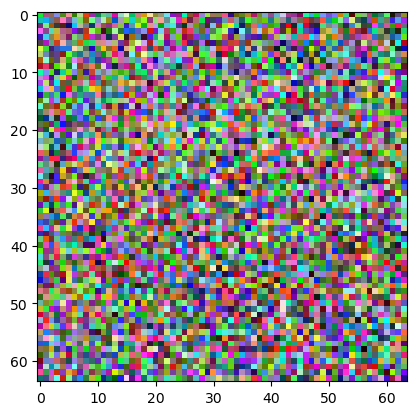

In [9]:
plt.imshow(test.tp(test.dummy_data.reshape((3,64,64))))